# Computational modeling : RL algorithms in a virtual environment

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [5]:
# Import the needed packages 
# 
# 1/ the usual suspects
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from jax.tree_util import tree_map
import jax.random as jr
import tensorflow_probability.substrates.jax.distributions as tfd 

# 2/ Useful functions from our package :
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.jax_toolbox import random_split_like_tree



# To make nice plots : 
from simulate.plot_trajectory import plot_training


# The simulated environment :
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import TrainingEnvironment,run_loop,generate_synthetic_data

# The methods to predict actions, compute the log-likelihoods and fit the models :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from functools import partial


# The artificial agents : 
from agents_no_ck import lat_assymetric_QL_agent_with_biais as labql_agent  # latent-assymetric-biaised-qlearning agent


In [6]:
NTRIALS = 10
T = 11

# MODEL CONSTANTS :
N_LATENT_STATES = 5

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 6
TRUE_FEEDBACK_STD = 0.025#0.025
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)

No = N_FEEDBACK_OUTCOMES
Ns = N_LATENT_STATES

# Depending on the dimensions of the problem :
models_constants = {
    "angle" : {
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    "distance" : {
        "N_actions" : 4,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    "position" : {
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns
    }
}
my_agent = partial(labql_agent,constants= models_constants)

Behaviour of one static biais agent with uniform biais :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19


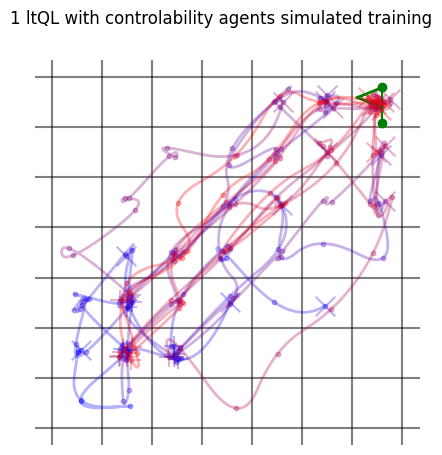

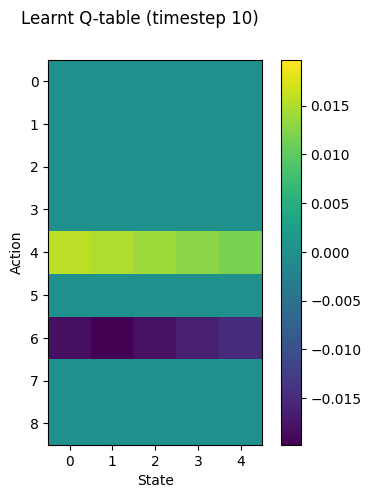

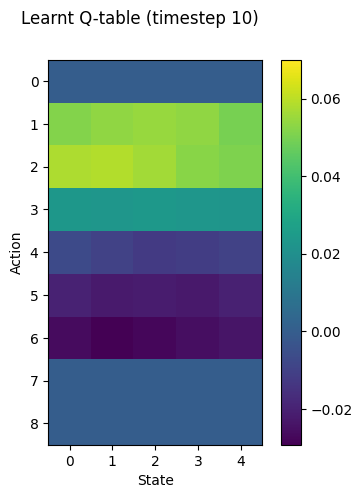

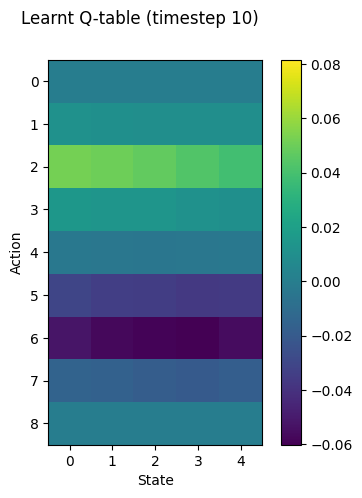

In [7]:
NTRIALS = 20
T = 11
test_run_hparams = {
    "angle":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.5,0.1,0.0,0.0,0.0]))[0],
        "beta_biais" : 0.0,
        "alpha_Q+":0.1,
        "alpha_Q-":0.1,
        "beta_Q" :50.0,
        "transition_alpha" : 0.3,
        "perception_sigma" : 0.1,
        "gamma_generalize" : 0.1
    },
    "position":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.5,0.1,0.0,0.0,0.0]))[0],
        "beta_biais" : 1.0,
        "alpha_Q+":0.2,
        "alpha_Q-":0.2,
        "beta_Q" :5.0,
        "transition_alpha" : 0.3,
        "perception_sigma" : 0.001,
        "gamma_generalize" : 2.0
    },
    "distance":{
        "biais":_normalize(jnp.array([0.4,0.3,0.0,0.3]))[0],
        "beta_biais" : 1.0,
        "alpha_Q+":0.2,
        "alpha_Q-":0.2,
        "beta_Q" :5.0,
        "transition_alpha" : 0.3,
        "perception_sigma" : 0.1,
        "gamma_generalize" : 2.0
    }
}


SEED = np.random.randint(1000)
params_final,training_hist = run_loop(ENVIRONMENT,my_agent(test_run_hparams),SEED,NTRIALS)
simulated_states = np.array(training_hist["env_states"])

fig,ax = plt.subplots(figsize= (5,5))
fig.suptitle("1 ltQL with controlability agents simulated training")
plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)


for trial in [0,5,-1]:
    (new_qt,new_B,vect_action_selected,current_stimuli) = training_hist["states"][trial]
    # print(np.stack(new_qt["angle"]).shape)
    
    t = 10
    
    one_training_episode_qtables = np.stack(new_qt["angle"])
    fig,ax = plt.subplots(1,figsize=(5,5))
    fig.suptitle("Learnt Q-table (timestep {})".format(t))
    im = ax.imshow(one_training_episode_qtables[t,...],cmap="viridis",vmin=np.min(one_training_episode_qtables),vmax=np.max(one_training_episode_qtables))
    ax.set_xlabel("State")
    ax.set_ylabel("Action")
    fig.colorbar(im)

Example of behaviour simulated by a given model in the environment :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


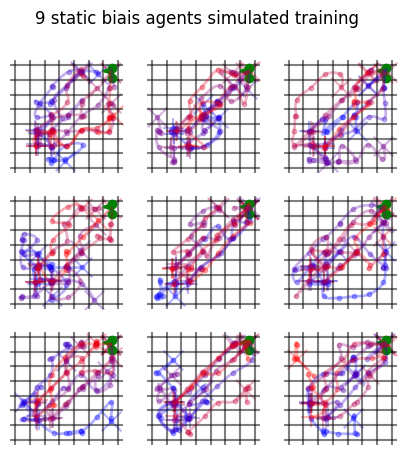

In [8]:
# We can encode static biases for a specific action modality using this model. The global temperature parameter
# beta indicates how likley the agent is to shift focus !

NTRIALS = 10
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 static biais agents simulated training")

test_run_hparams = {
    "angle":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.5,0.1,0.0,0.0,0.0]))[0],
        "beta_biais" : 0.0,
        "alpha_Q+":0.1,
        "alpha_Q-":0.1,
        "beta_Q" :50.0,
        "transition_alpha" : 0.3,
        "perception_sigma" : 0.1,
        "gamma_generalize" : 0.1
    },
    "position":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.5,0.1,0.0,0.0,0.0]))[0],
        "beta_biais" : 1.0,
        "alpha_Q+":0.2,
        "alpha_Q-":0.2,
        "beta_Q" :5.0,
        "transition_alpha" : 0.3,
        "perception_sigma" : 0.001,
        "gamma_generalize" : 2.0
    },
    "distance":{
        "biais":_normalize(jnp.array([0.4,0.3,0.0,0.3]))[0],
        "beta_biais" : 1.0,
        "alpha_Q+":0.2,
        "alpha_Q-":0.2,
        "beta_Q" :5.0,
        "transition_alpha" : 0.3,
        "perception_sigma" : 0.1,
        "gamma_generalize" : 2.0
    }
}

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    params_final,training_hist = run_loop(ENVIRONMENT,my_agent(test_run_hparams),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)


Generate some synthetic data for the model we're interested in, for the purpose of inverting it !

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
GT LL : 
{'angle': Array(-309.1826, dtype=float32), 'distance': Array(-272.54147, dtype=float32), 'position': Array(-433.0941, dtype=float32)}


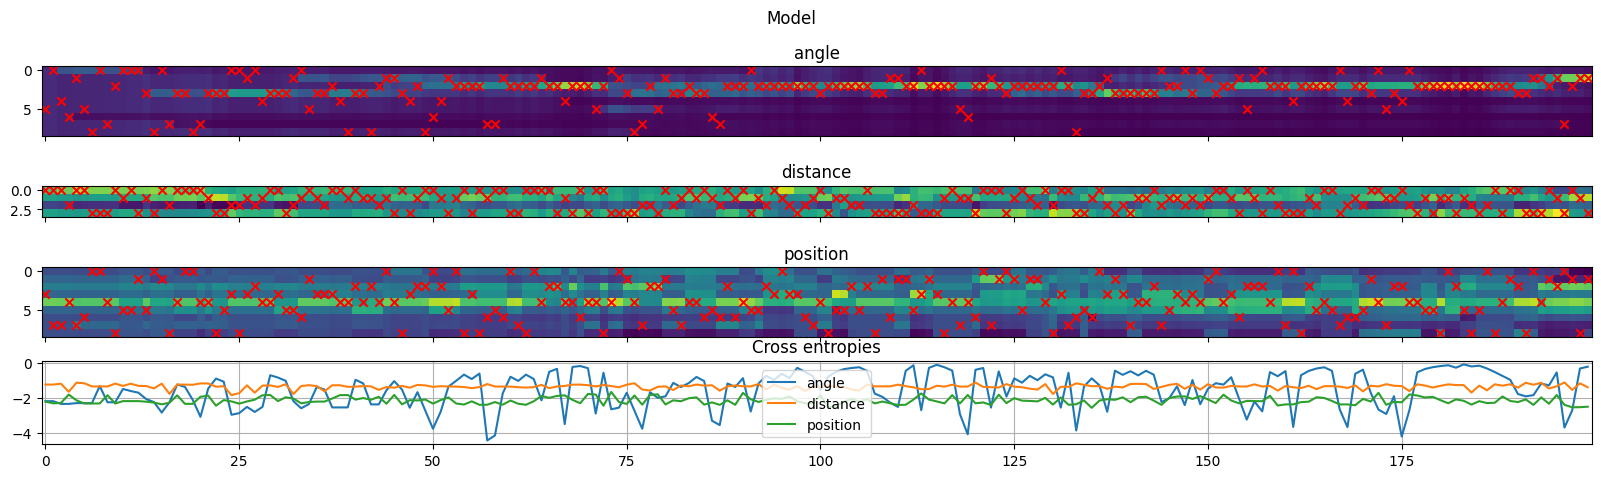

In [9]:
ground_truth_hparams = {
    "angle":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.5,0.1,0.0,0.0,0.0]))[0],
        "beta_biais" : 0.0,
        "alpha_Q+":0.1,
        "alpha_Q-":0.1,
        "beta_Q" :50.0,
        "transition_alpha" : 0.3,
        "perception_sigma" : 0.1,
        "gamma_generalize" : 0.1
    },
    "position":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.5,0.1,0.0,0.0,0.0]))[0],
        "beta_biais" : 1.0,
        "alpha_Q+":0.2,
        "alpha_Q-":0.2,
        "beta_Q" :5.0,
        "transition_alpha" : 0.3,
        "perception_sigma" : 0.001,
        "gamma_generalize" : 2.0
    },
    "distance":{
        "biais":_normalize(jnp.array([0.4,0.3,0.0,0.3]))[0],
        "beta_biais" : 1.0,
        "alpha_Q+":0.2,
        "alpha_Q-":0.2,
        "beta_Q" :5.0,
        "transition_alpha" : 0.3,
        "perception_sigma" : 0.1,
        "gamma_generalize" : 2.0
    }
}

n_trials = 20
SYNTHETIC_DATA = generate_synthetic_data(ENVIRONMENT,my_agent(ground_truth_hparams),
                                         n_trials=n_trials,seed = 1,verbose = True)
(formatted_stimuli,bool_stimuli,rewards,true_actions,tmtsp) = SYNTHETIC_DATA


# Optimal likelihood for the data (the best predictive power we should be able to achieve ):
lls,ces = compute_loglikelihood(SYNTHETIC_DATA,my_agent(ground_truth_hparams),"sum")
final_parameters,predicted_actions,state_history = compute_predicted_actions(SYNTHETIC_DATA,my_agent(ground_truth_hparams))
model_states,other_data = state_history

# plt.imshow(np.reshape(ck_history["position"],(-1,9)))
fig,axs = plt.subplots(len(true_actions)+1,1,figsize=(n_trials,5),sharex=True)
fig.suptitle("Model")

for i,key in enumerate(predicted_actions.keys()):
    ax = axs[i]

    N_action_cat = true_actions[key].shape[-1]
    
    prediction_map = np.reshape(predicted_actions[key],(-1,N_action_cat))
    ax.set_title(key)    
    ax.imshow(prediction_map.T)
        
    N_timesteps  = prediction_map.shape[0]
    ax.scatter(np.arange(N_timesteps),np.argmax(true_actions[key],axis=-1),color="red",marker="x")

ax = axs[-1]
ax.set_title("Cross entropies")
for mod,series in ces.items():
    ax.plot(series.flatten(),label=mod)
ax.legend()
ax.grid()

print("GT LL : ")
print(lls)

step 0, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([1240.3921, 3087.4543, 1243.6411, 1723.7863, 1896.4617, 3264.978 ,
       1346.1604, 1137.2483, 2087.796 , 1274.2257, 1449.1986, 1453.572 ,
       1305.7412, 1986.3983, 1588.4799, 1318.5945, 2173.1606, 3167.6082,
       2849.7173, 1285.1254], dtype=float32)
  batch_dim = 0
step 10, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([1134.868 , 1347.7561, 1178.4542, 1210.1016, 1276.8718, 1365.184 ,
       1243.6473, 1082.6604, 1398.1144, 1209.8652, 1178.0165, 1210.9835,
       1126.6776, 1171.1676, 1146.2035, 1215.9088, 1254.0883, 1528.2059,
       1356.488 , 1170.3934], dtype=float32)
  batch_dim = 0
step 20, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([1118.4485, 1160.6482, 1167.3019, 1181.1571, 1169.0839, 1203.924 ,
       1223.568 , 1082.3602, 1232.7146, 1188.5133, 1144.3192, 1148.9055,
       1102.2975, 1133.1464, 1151.900

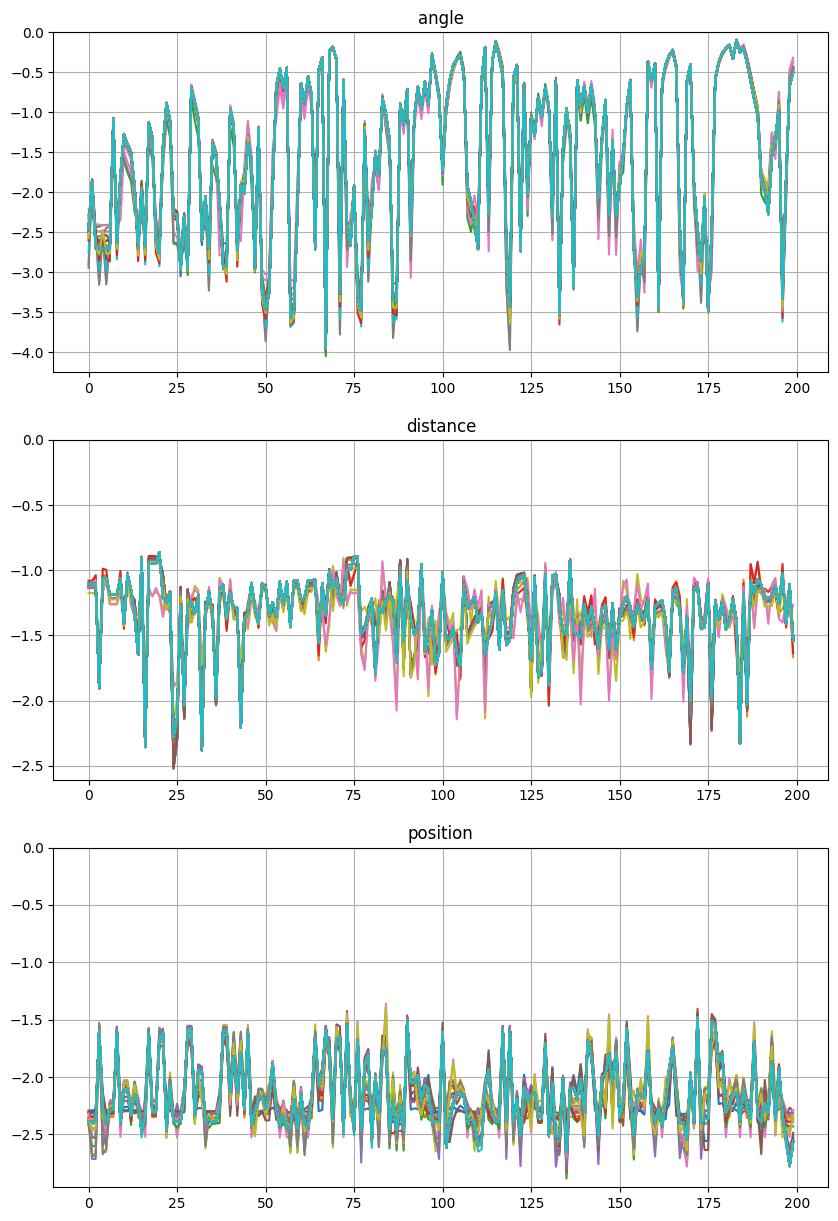

In [13]:
# Let's attempt the same, but using MAP fitting and ensuring the initial beta parameters are both quite high !


# Assuming uniform distributions for all initial parameter heads :
feature_range_tree ={
    "angle":{
        "biais" : jnp.array([-10,10,9]),
        "beta_biais" : jnp.array([-2,2]),
        "alpha_Q+" : jnp.array([-10,10]),
        "alpha_Q-" : jnp.array([-10,10]),
        "beta_Q" : jnp.array([-2,2]),
        "transition_alpha" : jnp.array([-10,10]),
        "perception_sigma" : jnp.array([-10,10]),
        "gamma_generalize" : jnp.array([-10,10])
    },
    "position":{
        "biais" : jnp.array([-10,10,9]),
        "beta_biais" : jnp.array([-2,2]),
        "alpha_Q+" : jnp.array([-10,10]),
        "alpha_Q-" : jnp.array([-10,10]),
        "beta_Q" : jnp.array([-2,2]),
        "transition_alpha" : jnp.array([-10,10]),
        "perception_sigma" : jnp.array([-10,10]),
        "gamma_generalize" : jnp.array([-10,10])
    },
    "distance":{
        "biais" : jnp.array([-10,10,4]),
        "beta_biais" : jnp.array([-2,2]),
        "alpha_Q+" : jnp.array([-10,10]),
        "alpha_Q-" : jnp.array([-10,10]),
        "beta_Q" : jnp.array([-2,2]),
        "transition_alpha" : jnp.array([-10,10]),
        "perception_sigma" : jnp.array([-10,10]),
        "gamma_generalize" : jnp.array([-10,10])
    }
}


zero_one_uni = tfd.Uniform(low=-1e-5,high=1.0+1e-5)  # Bounds may be a bit finnicky
beta_val = 10
beta_std = 5.0

# Assuming uniform distributions for all initial parameter heads :
parameter_prior_tree ={
    "angle":{
        "biais" : zero_one_uni,  # No priors on the individual biaises !
        "beta_biais" : tfd.Normal(beta_val, beta_std),
        "alpha_Q+" : zero_one_uni,
        "alpha_Q-" : zero_one_uni,
        "beta_Q" : tfd.Normal(beta_val, beta_std),
        "transition_alpha" : zero_one_uni,
        "perception_sigma" : tfd.Uniform(low=-1e-5,high=100.0),
        "gamma_generalize" : tfd.Uniform(low=-1e-5,high=100.0)
    },
    "position":{
        "biais" : zero_one_uni,  # No priors on the individual biaises !
        "beta_biais" : tfd.Normal(beta_val, beta_std),
        "alpha_Q+" : zero_one_uni,
        "alpha_Q-" : zero_one_uni,
        "beta_Q" : tfd.Normal(beta_val, beta_std),
        "transition_alpha" : zero_one_uni,
        "perception_sigma" : tfd.Uniform(low=-1e-5,high=100.0),
        "gamma_generalize" : tfd.Uniform(low=-1e-5,high=100.0)
    },
    "distance":{
        "biais" : zero_one_uni,  # No priors on the individual biaises !
        "beta_biais" : tfd.Normal(beta_val, beta_std),
        "alpha_Q+" : zero_one_uni,
        "alpha_Q-" : zero_one_uni,
        "beta_Q" : tfd.Normal(beta_val, beta_std),
        "transition_alpha" : zero_one_uni,
        "perception_sigma" : tfd.Uniform(low=-1e-5,high=100.0),
        "gamma_generalize" : tfd.Uniform(low=-1e-5,high=100.0)
    }
}

all_fin_params,(gt_mle,all_losses,all_param_histories),encoding_function = fit_map_agent(SYNTHETIC_DATA,
                            my_agent,feature_range_tree,parameter_prior_tree,jax.random.PRNGKey(0),
                            n_heads=20,num_steps=250,verbose=True,start_learning_rate=1e-1)

final_lls,cross_entropies = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,my_agent(encoding_function(x)),"sum"))(all_fin_params)


print(cross_entropies["angle"])
print(min(final_lls["angle"]))
print(max(final_lls["angle"]))
fig,axs = plt.subplots(3,1,figsize=(10,15))
for i,key in enumerate(cross_entropies.keys()):
    axs[i].set_title(key)
    for head in range(100):
        axs[i].plot(cross_entropies[key][head].flatten())
    axs[i].set_ylim(ymax=0.0)
    axs[i].grid()
plt.show()

Given the best match for subject parameters, we then reconstruct the evolution of model states / parameters across trials.

(20, 20, 11, 9, 5)
{'angle': {'alpha_Q+': Array([0.9827283 , 0.2022356 , 0.8842482 , 0.19353166, 0.9636749 ,
       0.19868939, 0.18722598, 0.23621434, 0.9116634 , 0.21254653,
       0.2008997 , 0.9460988 , 0.988857  , 0.20914428, 0.20032135,
       0.68942636, 0.51829284, 0.24451499, 0.2075518 , 0.2068081 ],      dtype=float32), 'alpha_Q-': Array([0.1817264 , 0.02595796, 0.2797406 , 0.03581025, 0.1573533 ,
       0.03642414, 0.00545318, 0.03007292, 0.21030298, 0.02775378,
       0.03671397, 0.17444746, 0.1200237 , 0.03022245, 0.03838973,
       0.08872064, 0.01277404, 0.06268561, 0.03844194, 0.04147584],      dtype=float32), 'beta_Q': Array([24.363186, 23.317646, 27.498285, 25.928741, 23.876324, 25.600525,
       26.506765, 23.27554 , 25.27715 , 23.111263, 24.005917, 24.047192,
       23.833565, 23.286335, 24.90009 , 25.226578, 28.657804, 25.744572,
       23.297092, 24.455393], dtype=float32), 'beta_biais': Array([2.3786395 , 5.567198  , 0.54873943, 1.568716  , 2.5823517 ,
       1.9

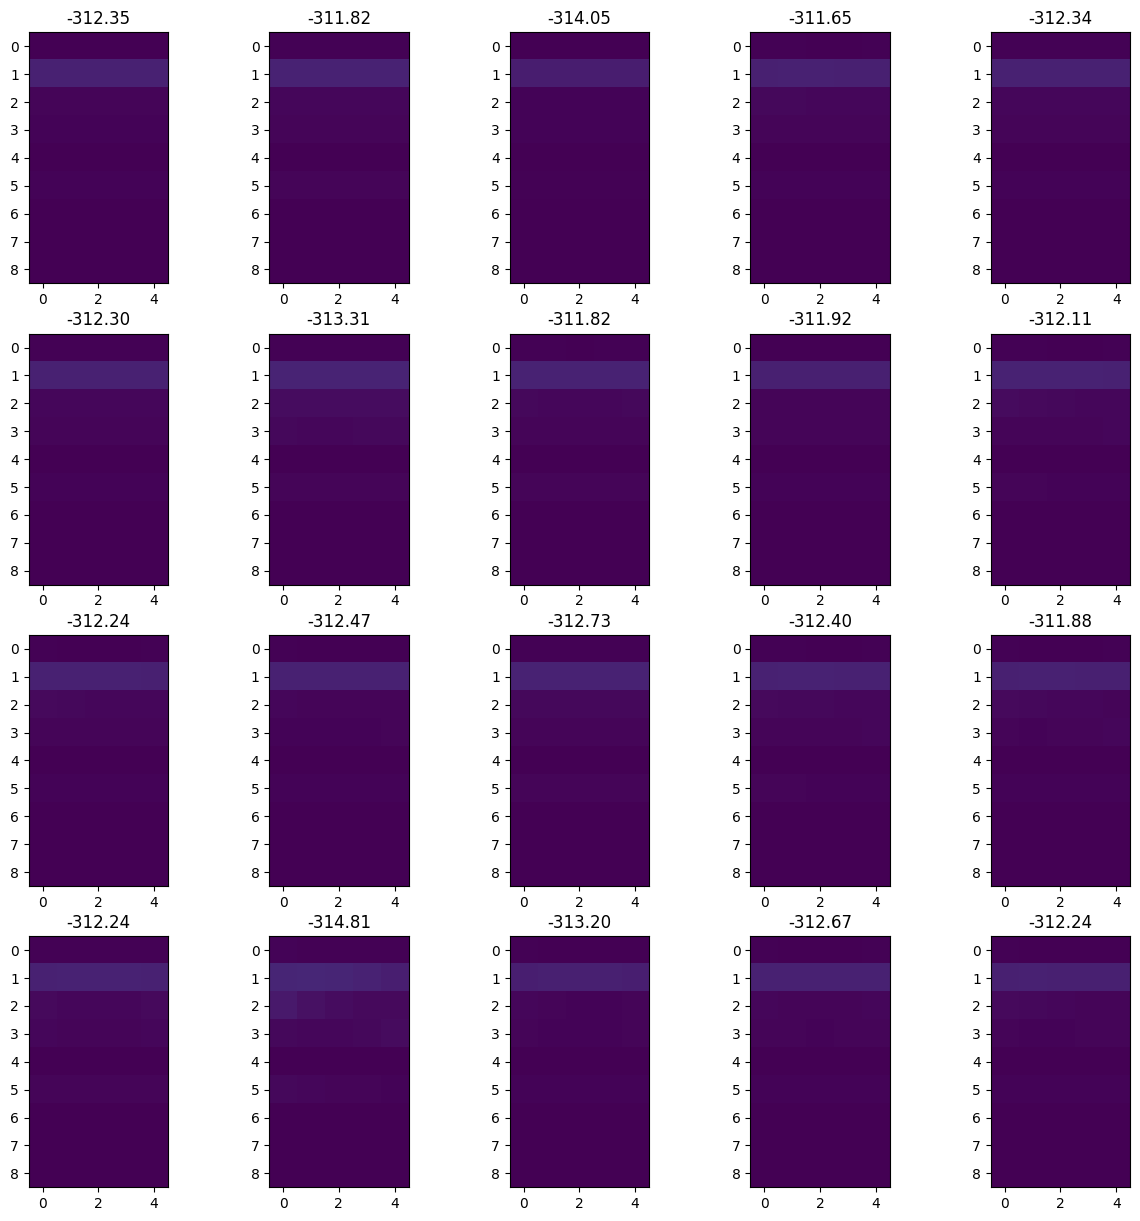

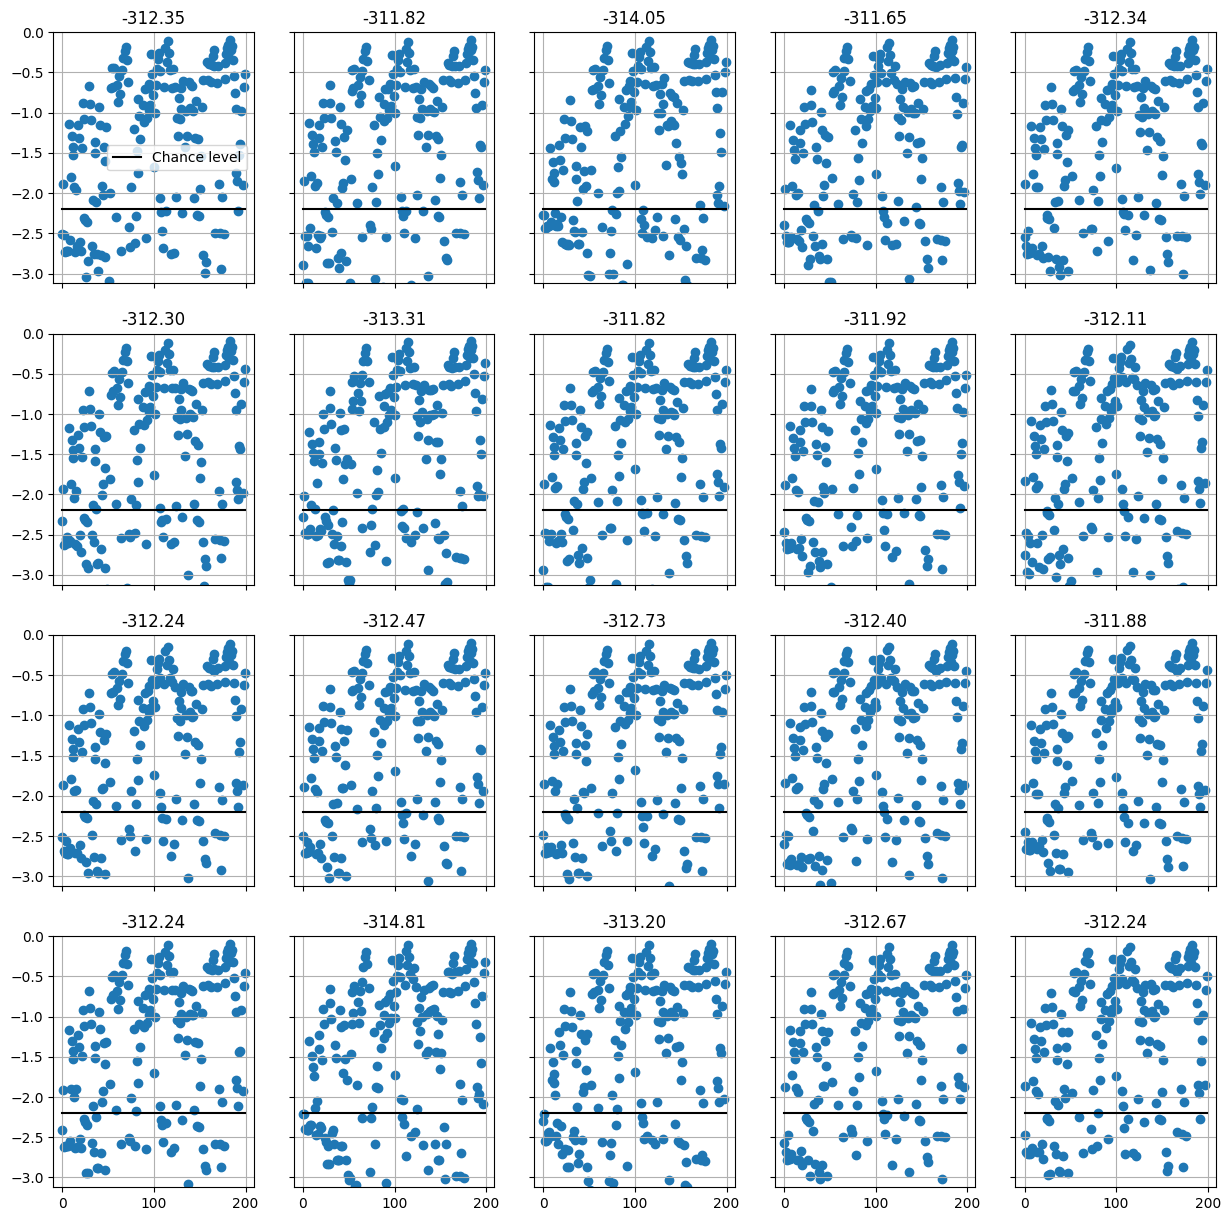

In [14]:
# We will need a random model to evaluate the goodness of our predictions ! 
from agents_no_ck import random_agent

random_ll_term,random_predictions,random_model_variables  = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,random_agent(encoding_function(x),models_constants),"sum",True))(all_fin_params)
random_logliks,random_cross_entropies = random_ll_term

ll_term,predictions,model_variables  = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,my_agent(encoding_function(x)),"sum",True))(all_fin_params)
model_states,other_data = model_variables

logliks,cross_entropies = ll_term
qtable,B,_,_ = model_states



print(qtable["angle"].shape)  # N_heads x N_trials x N_timesteps x (Qtable)



optimal_params = jax.vmap(lambda x : encoding_function(x))(all_fin_params)
print(optimal_params)

# The states of this model are None, so it's not very useful :p
fig,axs = plt.subplots(4,5,figsize=(15,15))
for k,ax in enumerate(axs.flatten()):
    ax.set_title("{:.2f}".format(float(logliks["angle"][k])))
    ax.imshow(qtable["angle"][k,-1,-1,...],vmin=0,vmax=1)
plt.show()


ce_plots = np.reshape(cross_entropies["angle"],(cross_entropies["angle"].shape[0],-1))
random_ce_plots = np.reshape(random_cross_entropies["angle"],(random_cross_entropies["angle"].shape[0],-1))
fig,axs = plt.subplots(4,5,figsize=(15,15),sharex=True,sharey=True)
LOWER_EDGE = np.mean([np.min(ce_plots),np.min(random_ce_plots)])
for k,ax in enumerate(axs.flatten()):
    ax.scatter(np.arange(ce_plots[k].shape[0]),ce_plots[k])
    
    if k == 0:
        ax.plot(random_ce_plots[k],color="black",label="Chance level")
    else:
        ax.plot(random_ce_plots[k],color="black")
    ax.set_ylim([LOWER_EDGE,0])
    ax.grid()
    ax.set_title("{:.2f}".format(float(logliks["angle"][k])))

axs.flatten()[0].legend()
plt.show()
